# Capstone - Financial Forecasting

Import fundamental packages

In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import pandas_datareader.data as web
import datetime
from datetime import timedelta
import seaborn as sn
from pandas import Series
from matplotlib import pyplot
from pandas import Series
from matplotlib import pyplot
# Pretty display for notebooks
%matplotlib inline
from IPython.display import display # Allows the use of display() for DataFrames
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from matplotlib.pyplot import savefig
import time
from scipy.misc import imresize
from sklearn.preprocessing import MinMaxScaler

setting up proxy

In [2]:
import sys,os,os.path
os.environ['HTTP_PROXY']="http://194.145.60.1:9400"
os.environ['HTTPS_PROXY']="http://194.145.60.1:9400"
#os.environ['HTTP_PROXY']=""
#os.environ['HTTPS_PROXY']=""
import requests
requests.get("http://google.com")

<Response [200]>

# 1. Get financial data 

Run this section if you want to download the data yourself. It is not compulsary, as the data is stored as "Data-5year-2012-2017.csv", and loaded in the relevant sections.

- Financial data is downloaded via the quandl API (https://www.quandl.com/)
    - Time interval: 2012-01-01 -- 2017-01-01
    - Data type: Adj. Close from NASDAQ 100 (Here: Only 88 companies, 12 had too many missing values)
- .csv file is saved on HDD for later processing

Download data from quandl

In [3]:
import quandl
quandl.ApiConfig.api_key = "U5cJSsnv4Ad7UUnHNGu8"

In [4]:
#Nasdaq 100 Company list
companies = ["WIKI/ATVI.11","WIKI/ADBE.11","WIKI/AKAM.11","WIKI/ALXN.11","WIKI/GOOGL.11","WIKI/AMZN.11","WIKI/AAL.11","WIKI/AMGN.11","WIKI/ADI.11","WIKI/AAPL.11","WIKI/AMAT.11","WIKI/ADSK.11","WIKI/ADP.11","WIKI/BIDU.11","WIKI/BIIB.11","WIKI/BMRN.11","WIKI/CA.11","WIKI/CELG.11","WIKI/CERN.11","WIKI/CHKP.11","WIKI/CTAS.11","WIKI/CSCO.11","WIKI/CTXS.11","WIKI/CTSH.11","WIKI/CMCSA.11","WIKI/COST.11","WIKI/CSX.11","WIKI/XRAY.11","WIKI/DISCA.11","WIKI/DISH.11","WIKI/DLTR.11","WIKI/EBAY.11","WIKI/EA.11","WIKI/EXPE.11","WIKI/ESRX.11","WIKI/FAST.11","WIKI/FISV.11","WIKI/GILD.11","WIKI/HAS.11","WIKI/HSIC.11","WIKI/HOLX.11","WIKI/IDXX.11","WIKI/ILMN.11","WIKI/INCY.11","WIKI/INTC.11","WIKI/INTU.11","WIKI/ISRG.11","WIKI/JBHT.11","WIKI/KLAC.11","WIKI/LRCX.11","WIKI/LBTYA.11","WIKI/MAR.11","WIKI/MAT.11","WIKI/MXIM.11","WIKI/MCHP.11","WIKI/MU.11","WIKI/MDLZ.11","WIKI/MSFT.11","WIKI/MNST.11","WIKI/MYL.11","WIKI/NFLX.11","WIKI/NVDA.11","WIKI/ORLY.11","WIKI/PCAR.11","WIKI/PAYX.11","WIKI/PCLN.11","WIKI/QCOM.11","WIKI/REGN.11","WIKI/ROST.11","WIKI/STX.11","WIKI/SIRI.11","WIKI/SWKS.11","WIKI/SBUX.11","WIKI/SYMC.11","WIKI/TSLA.11","WIKI/TXN.11","WIKI/TSCO.11","WIKI/TMUS.11","WIKI/FOX.11","WIKI/ULTA.11","WIKI/VRSK.11","WIKI/VRTX.11","WIKI/VIAB.11","WIKI/VOD.11","WIKI/WBA.11","WIKI/WDC.11","WIKI/WYNN.11","WIKI/XLNX.11"]

In [14]:
#Download via API
tickerstart = time.time()
mydata = quandl.get(companies, start_date="2012-01-01", end_date="2017-01-01")
tickerend = time.time()
print(tickerend-tickerstart)

70.93799996376038


In [54]:
#save as csv
mydata.to_csv("Data-5year-2012-2017.csv")

# 2. Develop ordering algorithm for companies (PCA)

In this section the sorting algorithm is explained. Run this section if you want to check for functionality. However it is not compulsary as the PC are loaded from HDD in the appropirate sections.

Idea: Cluster data into groups to get some order into financial data. This ordered data can then be used to create images which are processed with DNN image processing techniques.
Ordering process: 
- Generate 5 year image of NASDAQ 100 
- Generate 1 Dimensional feature space with PCA 
- Sort companies by PC eigenvalue

In [4]:
#load data from hdd
mydata=pd.read_csv("Data-5year-2012-2017.csv")
mydata[['Date']] = mydata[['Date']].apply(pd.to_datetime, errors='ignore')
mydata=mydata.set_index(mydata["Date"])
mydata = mydata.drop("Date",axis=1)

In [5]:
#check for nans. Nancheck.csv contains list of columns with NaN indication.
output = pd.isnull(mydata).sum() > 0
output.to_csv("Nancheck.csv")
print(pd.isnull(mydata).sum().sum())

0


In [6]:
#Select 5 year timeinterval
AdjCloseLong = mydata.loc["2012-1-1":"2017-1-1"]

#Bring into shape for image
arraylong = np.flip(np.transpose(np.array(AdjCloseLong, np.float32)[:, :]),axis=1)
dfLong = pd.DataFrame(arraylong)

In [7]:
AdjCloseLong.head(5)

,WIKI/ATVI - Adj. Close,WIKI/ADBE - Adj. Close,WIKI/AKAM - Adj. Close,WIKI/ALXN - Adj. Close,WIKI/GOOGL - Adj. Close,WIKI/AMZN - Adj. Close,WIKI/AAL - Adj. Close,WIKI/AMGN - Adj. Close,WIKI/ADI - Adj. Close,WIKI/AAPL - Adj. Close,...,WIKI/FOX - Adj. Close,WIKI/ULTA - Adj. Close,WIKI/VRSK - Adj. Close,WIKI/VRTX - Adj. Close,WIKI/VIAB - Adj. Close,WIKI/VOD - Adj. Close,WIKI/WBA - Adj. Close,WIKI/WDC - Adj. Close,WIKI/WYNN - Adj. Close,WIKI/XLNX - Adj. Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,11.477656,28.57,32.93,70.57,333.735209,179.03,13.303512,56.676913,30.734273,52.848787,...,15.598020,63.384438,39.36,32.23,40.245928,26.898992,29.271975,27.306007,91.565750,28.039940
2012-01-04,11.388281,28.28,32.44,70.29,335.174652,177.51,13.069661,56.367493,30.691622,53.132802,...,15.497765,65.629098,38.98,32.20,40.237162,26.794234,29.068329,27.588057,89.991048,27.741735
2012-01-05,11.392985,28.48,32.43,72.41,330.525300,177.61,14.212931,56.942130,30.828105,53.722681,...,15.639793,68.783487,39.13,33.12,41.175153,26.437104,28.970933,28.874913,89.051046,27.988078
2012-01-06,11.515288,28.72,32.76,74.45,326.016381,182.61,14.550716,57.251551,30.623381,54.284287,...,15.539538,68.743934,39.37,34.05,41.595934,26.522815,29.289684,29.518340,85.917709,27.806562
2012-01-09,11.477656,28.53,32.61,74.27,312.193712,178.56,14.862517,56.756478,31.220494,54.198183,...,15.539538,69.149357,39.38,35.68,40.850801,26.341870,29.661560,29.747506,85.676683,28.411616


In [17]:
AdjCloseLong.describe()

,WIKI/ATVI - Adj. Close,WIKI/ADBE - Adj. Close,WIKI/AKAM - Adj. Close,WIKI/ALXN - Adj. Close,WIKI/GOOGL - Adj. Close,WIKI/AMZN - Adj. Close,WIKI/AAL - Adj. Close,WIKI/AMGN - Adj. Close,WIKI/ADI - Adj. Close,WIKI/AAPL - Adj. Close,...,WIKI/FOX - Adj. Close,WIKI/ULTA - Adj. Close,WIKI/VRSK - Adj. Close,WIKI/VRTX - Adj. Close,WIKI/VIAB - Adj. Close,WIKI/VOD - Adj. Close,WIKI/WBA - Adj. Close,WIKI/WDC - Adj. Close,WIKI/WYNN - Adj. Close,WIKI/XLNX - Adj. Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,22.226302,65.095218,52.089247,135.770213,543.855351,406.004230,38.328121,117.034692,47.477466,88.143001,...,27.242712,134.672903,64.466432,83.430071,55.136270,29.738342,60.122436,60.531728,117.447758,39.834672
std,9.963667,23.842798,12.779935,35.293812,158.929535,182.712524,8.671458,33.675673,9.945561,20.965031,...,5.178962,54.210958,11.625000,27.980155,14.826161,3.620722,20.160292,21.652809,40.662163,6.872013
min,10.077590,28.280000,27.440000,70.290000,280.390539,175.930000,13.069661,56.367493,30.167507,50.928800,...,15.497765,63.384438,38.980000,32.200000,29.889198,23.410218,26.021507,25.384539,49.536108,26.791623
25%,13.897245,42.925000,40.805000,102.682500,406.893541,266.627500,33.237752,88.546633,40.089028,70.194775,...,24.471376,92.650000,58.765000,61.037500,41.628140,27.733697,42.429018,41.765654,90.655420,33.759438
50%,19.917526,68.115000,52.655000,132.282500,548.590000,333.060000,38.761908,114.364869,46.831193,89.182554,...,28.224109,115.570000,63.560000,81.405000,52.652905,29.100620,62.687877,57.948526,101.880862,40.599762
75%,30.283465,83.517500,60.935000,167.797500,681.140000,534.012500,43.230474,148.049196,55.235263,106.912899,...,31.510640,165.722500,73.907500,104.830000,68.685975,30.740785,79.413694,79.697765,142.454537,44.573863
max,45.197507,110.810000,78.360000,207.840000,835.740000,844.360000,63.399547,170.848455,73.090050,126.931724,...,36.182463,275.890000,85.750000,141.480000,81.034143,41.839635,92.848360,105.021682,228.264729,60.231455


Normalize for each company as preparation for PCA

In [8]:
from sklearn import preprocessing
x = dfLong.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfLong_scaled = pd.DataFrame(x_scaled)

Perform PCA and reduce to 1 Dimension

In [9]:
from sklearn.decomposition import PCA
# Apply PCA with one dimension
Transform2D = PCA(n_components=1)
pca = Transform2D.fit(dfLong_scaled)

reduced_data = pca.transform(dfLong_scaled)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1'])

In [10]:
reduced_data.head(5)

,Dimension 1
0,-2.146323
1,-0.722234
2,-1.081622
3,1.813868
4,15.564890


Plot results of PC as histogram

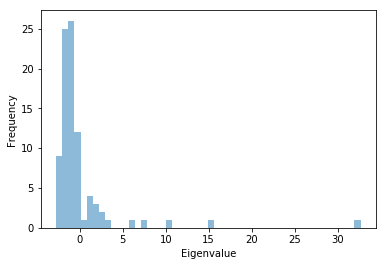

In [11]:
plt.hist(reduced_data["Dimension 1"], bins=50,alpha=0.5)
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.show()

Save PC for sorting in later data processing

In [12]:
np.save("PCAForSorting",reduced_data["Dimension 1"])
preds = reduced_data["Dimension 1"]

Test: Sort by PCA and plot results

In [13]:
dfLong["PCA"] = reduced_data["Dimension 1"]
SortedLong = dfLong.sort_values("PCA")
dfLongSorteddisplay = SortedLong.drop('PCA', 1)

Image of unsorted companies

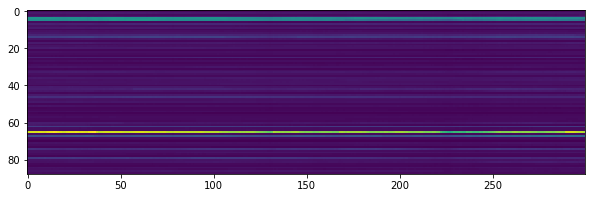

In [14]:
dfLongdisplay = dfLong.drop('PCA', 1)
displaynp = dfLongdisplay.values
plt.figure(figsize=(10,10))
plt.imshow(displaynp[:,:300])
savefig("unsorted_PCA.pdf")
plt.show()

Image of sorted companies

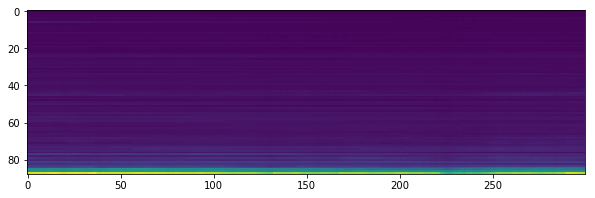

In [15]:
displaynp = dfLongSorteddisplay.values
plt.figure(figsize=(10,10))
plt.imshow(displaynp[:,:300])
savefig("sorted_PCA.pdf")
plt.show()

# 3. Test image creation for CNN

This section shows for two example images, how the images for the CNN are created step by step and put together in a tensor. 

First test: load two different time intervals, create images (np arrays) and sort them by clustering obtained in last section

In [218]:
mydata=pd.read_csv("Data-5year-2012-2017.csv")#,index_col="Date")
mydata[['Date']] = mydata[['Date']].apply(pd.to_datetime, errors='ignore')
mydata=mydata.set_index(mydata["Date"])
mydata = mydata.drop("Date",axis=1)

preds = np.load("PCAForSorting.npy")

In [220]:
AdjClose = mydata.loc["2012-1-1":"2013-1-1"]
AdjClose2 = mydata.loc["2012-1-10":"2013-1-8"]

Plot for overview

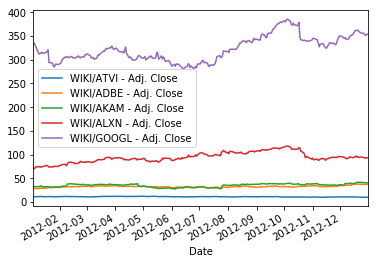

In [223]:
AdjClose.iloc[:,:5].plot(legend=True)

Bring into shape for 2D images

-> Normalize and transpose

In [20]:
AdjCloseNorm = AdjClose*1./np.max(AdjClose, axis=0)
array1 = np.flip(np.transpose(np.array(AdjCloseNorm, np.float32)[:, :]),axis=1)

print(array1.shape)

(88, 250)


-> Sort by PCA

In [21]:
AdjClosedf = pd.DataFrame(array1)
AdjClosedf["cluster"] = preds
AdjCloseSorted = AdjClosedf.sort_values("cluster")
AdjCloseSorted = AdjCloseSorted.drop('cluster', 1)

-> Bring into right shape for appending multiple images

In [22]:
arrayAdjClosed1 = np.array(AdjCloseSorted, np.float32)[newaxis, :, :]
print(arrayAdjClosed1.shape)

(1, 88, 250)


-> Do the same for second image

In [23]:
AdjClose2 = AdjClose2*1./np.max(AdjClose2, axis=0)
array2 = np.flip(np.transpose(np.array(AdjClose2, np.float32)[:, :]),axis=1)
print(array2.shape)

AdjClosedf2 = pd.DataFrame(array2)
AdjClosedf2["cluster"] = preds
AdjCloseSorted2 = AdjClosedf2.sort_values("cluster")
AdjCloseSorted2 = AdjCloseSorted2.drop('cluster', 1)

arrayAdjClosed2 = np.array(AdjCloseSorted2, np.float32)[newaxis, :, :]
print(arrayAdjClosed2.shape)

(88, 250)
(1, 88, 250)


-> Generate Complete Tensor

In [24]:
final = np.append(arrayAdjClosed1, arrayAdjClosed2, axis=0)
print(final.shape)

(2, 88, 250)


Plot First Image

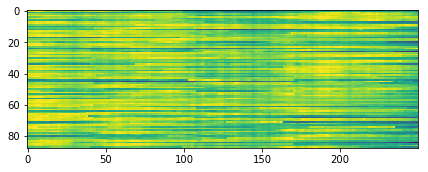

In [25]:
plt.figure(figsize = (7,7))
plt.autoscale(True)
plt.imshow(final[0,:,:])
plt.show()

-> Plot second image

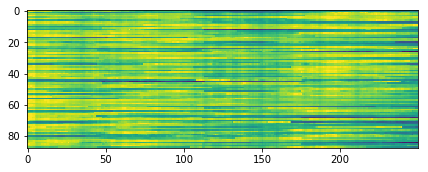

In [26]:
plt.figure(figsize = (7,7))
plt.autoscale(True)
plt.imshow(final[1,:,:])
plt.show()

-> Test pooling on images (Required in CNNs later on)

In [27]:
from skimage.measure import block_reduce
maxpooled = block_reduce(final[0,:,:], (5,5), np.average)

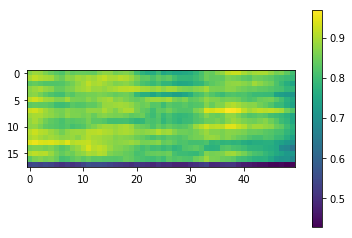

In [28]:
plt.imshow(maxpooled)
plt.colorbar()
plt.show()

Result: Some pattern are detectable by eye, looks promising for CNN approach

## 4. Automize Tensor Generation for Neural Networks, from complete dataframe that has been generated with quandl

In this section, the 5 year dataframe that has been downloaded via quandl will be transformed into input images and targets. This section has to be run in order to supply the ANNs with data.

How the tensor is created
- Normalize entire 5 year dataframe for each company seperately
- Extract last 250 available data points (approx. 1 year of data) => 1 image 
- Shift one day for 5 years (2012-2017) -> ~250 images per year, Approximation:(5 * 250)-30 = 1220 images
- Final output: np array with dimensions: 1220 x 88 x 250 (1220 images x 88 companies x 250 timepoints in image)

Load dataset and PCA for sorting

In [2]:
mydata=pd.read_csv("Data-5year-2012-2017.csv")#,index_col="Date")
mydata[['Date']] = mydata[['Date']].apply(pd.to_datetime, errors='ignore')
mydata=mydata.set_index(mydata["Date"])
mydata = mydata.drop("Date",axis=1)

preds = np.load("PCAForSorting.npy")

In [3]:
mydata.head(5)

,WIKI/ATVI - Adj. Close,WIKI/ADBE - Adj. Close,WIKI/AKAM - Adj. Close,WIKI/ALXN - Adj. Close,WIKI/GOOGL - Adj. Close,WIKI/AMZN - Adj. Close,WIKI/AAL - Adj. Close,WIKI/AMGN - Adj. Close,WIKI/ADI - Adj. Close,WIKI/AAPL - Adj. Close,...,WIKI/FOX - Adj. Close,WIKI/ULTA - Adj. Close,WIKI/VRSK - Adj. Close,WIKI/VRTX - Adj. Close,WIKI/VIAB - Adj. Close,WIKI/VOD - Adj. Close,WIKI/WBA - Adj. Close,WIKI/WDC - Adj. Close,WIKI/WYNN - Adj. Close,WIKI/XLNX - Adj. Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,11.477656,28.57,32.93,70.57,333.735209,179.03,13.303512,56.676913,30.734273,52.848787,...,15.598020,63.384438,39.36,32.23,40.245928,26.898992,29.271975,27.306007,91.565750,28.039940
2012-01-04,11.388281,28.28,32.44,70.29,335.174652,177.51,13.069661,56.367493,30.691622,53.132802,...,15.497765,65.629098,38.98,32.20,40.237162,26.794234,29.068329,27.588057,89.991048,27.741735
2012-01-05,11.392985,28.48,32.43,72.41,330.525300,177.61,14.212931,56.942130,30.828105,53.722681,...,15.639793,68.783487,39.13,33.12,41.175153,26.437104,28.970933,28.874913,89.051046,27.988078
2012-01-06,11.515288,28.72,32.76,74.45,326.016381,182.61,14.550716,57.251551,30.623381,54.284287,...,15.539538,68.743934,39.37,34.05,41.595934,26.522815,29.289684,29.518340,85.917709,27.806562
2012-01-09,11.477656,28.53,32.61,74.27,312.193712,178.56,14.862517,56.756478,31.220494,54.198183,...,15.539538,69.149357,39.38,35.68,40.850801,26.341870,29.661560,29.747506,85.676683,28.411616


- toPredictIndex: First Day of target
- PredictionTimepoints: number of datapoints for NN input data

In [3]:
#Define starting point for target and number of timepoints that are used as input
PredictionTimepoints = 250
FirstIndex = 250

MaxPoints = mydata.shape[0]-FirstIndex

## 4.1 Data preparation for MLP and CNNs:
- In the next cell , inputs and targets are created for the NNs (specify with/without prior normalization, MLP/CNN, custom CNN/transfer learning CNN, stock prediction absolute/percent)
- Details: For all companies create input vector of past stock prices and output vector of the next day.
- Note: Three channel images are requiredfor transfer learning (here:Xception)! Solution: all 3 channels contain
the same pixels

Output: Complete input and output for multivariate in and output (MLP type 2 and CNN)

In [457]:
MLP = True# False => CNN
normalization = False
percent = False
transfer = False # False => custom CNN

In [458]:
if (transfer==True):
    DataCollection = np.empty([1,250,88,3])
else:
    DataCollection = np.empty([1,250,88])
    
TargetCollection = np.empty([1,88])


mydataPP = mydata.copy(deep=True)
toPredictIndex = FirstIndex

#Normalization if required
if (normalization==True):
    mydataNP = mydata.values
    scaler = MinMaxScaler()  
    mydataNormalizedNP = scaler.fit_transform(mydataNP)
    mydataPP = pd.DataFrame(mydataNormalizedNP)

#FIRST define target day, THEN extract image of past data

for i in range(MaxPoints):
    
    #START CREATE OUTPUT VECTORS
    
    if (percent==True):
        PredictTemp = 100*(mydata.iloc[toPredictIndex]-mydata.iloc[toPredictIndex-1])/mydata.iloc[toPredictIndex-1]
    else:
        PredictTemp = mydataPP.iloc[toPredictIndex]
   
    arrayPredtemp = np.array(PredictTemp, np.float32)[newaxis,:]
    TargetCollection = np.append(TargetCollection, arrayPredtemp, axis=0)    
    
    
    #START CREATE IMAGES
    end = toPredictIndex
    start = end  - PredictionTimepoints
    
    
    AdjCloseTemp = mydataPP.iloc[start : end]
    
    #Ordering for CNN
    if (MLP==False):
        arrayTemp = np.flip(np.transpose(np.array(AdjCloseTemp, np.float32)[:, :]),axis=1)
        AdjCloseTemp = pd.DataFrame(arrayTemp)
        AdjCloseTemp["cluster"] = preds
        AdjCloseTemp = AdjCloseTemp.sort_values("cluster")
        AdjCloseTemp = AdjCloseTemp.drop('cluster', 1)
        arrayTemp = np.transpose(np.flip(AdjCloseTemp.values,axis=1))
        AdjCloseTemp = pd.DataFrame(arrayTemp)
        
    AdjCloseTemp_Array = AdjCloseTemp.values
    
    
    if (transfer==True):
        arrayAdjClosedTemp = np.array(AdjCloseTemp_Array, np.float32)[newaxis, :, :, newaxis]
        arrayAdjClosedTempFinal = np.append(arrayAdjClosedTemp , arrayAdjClosedTemp, axis=3)
        arrayAdjClosedTempFinal = np.append(arrayAdjClosedTempFinal , arrayAdjClosedTemp, axis=3)
        DataCollection = np.append(DataCollection, arrayAdjClosedTempFinal, axis=0)
    else:
        arrayAdjClosedTemp = np.array(AdjCloseTemp_Array, np.float32)[newaxis, :,:]
        DataCollection = np.append(DataCollection, arrayAdjClosedTemp, axis=0)
    
    #END CREATE IMAGES
    
    toPredictIndex += 1

   
DataCollection = DataCollection[1:DataCollection.shape[0],:,:]
TargetCollection = TargetCollection[1:TargetCollection.shape[0],:]

#For CNN reshape is required
if (MLP==False)&(transfer==False):
    DataCollection  = DataCollection.reshape(DataCollection.shape[0], DataCollection.shape[1], DataCollection.shape[2], 1)
    
print(DataCollection.shape)
print(TargetCollection.shape)

(1008, 250, 88)
(1008, 88)


Check images (only for CNN data)

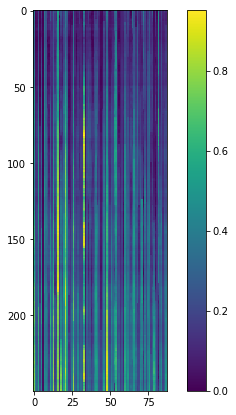

In [217]:
#Define slice
slice = 200
if (transfer==True):
    plt.figure(figsize = (7,7))
    plt.autoscale(True)
    plt.imshow(DataCollection[slice,:,:,2])
    plt.colorbar()
    plt.show()    
else:
    plt.figure(figsize = (7,7))
    plt.autoscale(True)
    plt.imshow(DataCollection[slice,:,:,0])
    plt.colorbar()
    plt.show()

__MLP type 1 Data Splitting:__
Run the following cell to create Data and Target for single companies as in and outputs (MLP type 1)

In [466]:
AppleData = np.copy(DataCollection[:,:,78]) #for WBC 85, for FOX 78, for Apple 9
AppleTarget = np.copy(TargetCollection[:,78])
print(AppleData.shape)
print(AppleTarget.shape)

(1008, 250)
(1008,)


Train, test , validation split for MLP type 1

In [467]:
#number of training samples
trainsamples = AppleData.shape[0]*0.7
print(trainsamples)
X_train = np.copy(AppleData[:706,:])
y_train = np.copy(AppleTarget[:706])
X_valid = np.copy(AppleData[705:862,:])
y_valid = np.copy(AppleTarget[705:862])
X_test = np.copy(AppleData[861:,:])
y_test = np.copy(AppleTarget[861:])
print(X_train.shape)

705.5999999999999
(706, 250)


__MLP type 2 Data Splitting:__Train, test , validation split for MLP type 2

In [410]:
X_train = np.copy(DataCollection[:706,:])
y_train = np.copy(TargetCollection[:706,:])
X_valid = np.copy(DataCollection[705:862,:])
y_valid = np.copy(TargetCollection[705:862,:])
X_test = np.copy(DataCollection[861:,:])
y_test = np.copy(TargetCollection[861:,:])
print(X_train.shape)

(706, 250, 88)


__CNN Data Splitting:__Train, test , validation split for CNN

In [405]:
X_train = np.copy(DataCollection[:706,:,:])
y_train = np.copy(TargetCollection[:706,:])
X_valid = np.copy(DataCollection[705:862,:,:])
y_valid = np.copy(TargetCollection[705:862,:])
X_test = np.copy(DataCollection[861:,:,:])
y_test = np.copy(TargetCollection[861:,:])
print(X_train.shape)

705.5999999999999


In [227]:
#from sklearn.model_selection import train_test_split

#X_train, X, y_train, y = train_test_split(DataCollection,TargetCollection,test_size=0.3,train_size=0.7)
#X_test, X_valid, y_test, y_valid = train_test_split(X,y,test_size = 0.5,train_size =0.5)

# 5. Neural Network Training and scoring (Keras models)

Load Keras stuff

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


## 5.1 MLPs for benchmarking

MLP type 1: MLP for single company in and output

In [14]:
def baseline_model():
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_dim=250))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
    # model.load_weights('saved_models/weights.best.from_scratch_MLP_APPLE.hdf5')
    return model

MLP type 2:for multi company in and output

In [398]:
def MLP_B1():
    model = Sequential()
    model.add(Flatten(input_shape=(250,88)))
   # model.add(Dense(5000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_MLP_multi_norm.hdf5')
    return model

In [441]:
def MLP_B2():
    model = Sequential()
    model.add(Flatten(input_shape=(250,88)))
   # model.add(Dense(5000, activation='relu'))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_MLP_multi_norm.hdf5')
    return model

In [437]:
epochs = 10000

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# specify MLP 1 or 2 here

estimator = KerasRegressor(build_fn=MLP_B2, epochs=epochs, batch_size=705, verbose=1)

# Enter checkpoint filename here
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_MLPtype2_B2.hdf5', 
                               verbose=1, save_best_only=True)

estimator.fit(X_train, y_train,  validation_data=(X_valid, y_valid),callbacks=[checkpointer])

Train on 706 samples, validate on 157 samples
Epoch 1/10000
706/706 [==============================] - 8s - loss: 6.4105 - mean_squared_error: 6.4105 - val_loss: 1035.7261 - val_mean_squared_error: 1035.7261
Epoch 2/10000
706/706 [==============================] - 7s - loss: 512.3634 - mean_squared_error: 512.3634 - val_loss: 20.2921 - val_mean_squared_error: 20.2921
Epoch 3/10000
706/706 [==============================] - 7s - loss: 11.5626 - mean_squared_error: 11.5626 - val_loss: 8.1814 - val_mean_squared_error: 8.1814
Epoch 4/10000
706/706 [==============================] - 6s - loss: 4.9258 - mean_squared_error: 4.9258 - val_loss: 3.3875 - val_mean_squared_error: 3.3875
Epoch 5/10000
706/706 [==============================] - 7s - loss: 2.5547 - mean_squared_error: 2.5547 - val_loss: 1.9859 - val_mean_squared_error: 1.9859
Epoch 6/10000
706/706 [==============================] - 6s - loss: 1.9738 - mean_squared_error: 1.9738 - val_loss: 1.4018 - val_mean_squared_error: 1.4018
Epoc

706/706 [==============================] - 7s - loss: 0.2286 - mean_squared_error: 0.2286 - val_loss: 0.1812 - val_mean_squared_error: 0.1812
Epoch 48/10000
706/706 [==============================] - 6s - loss: 0.2198 - mean_squared_error: 0.2198 - val_loss: 0.1679 - val_mean_squared_error: 0.1679
Epoch 49/10000
706/706 [==============================] - 7s - loss: 0.2125 - mean_squared_error: 0.2125 - val_loss: 0.1604 - val_mean_squared_error: 0.1604
Epoch 50/10000
706/706 [==============================] - 4s - loss: 0.2151 - mean_squared_error: 0.2151 - val_loss: 0.1623 - val_mean_squared_error: 0.1623
Epoch 51/10000
706/706 [==============================] - 4s - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 0.1653 - val_mean_squared_error: 0.1653
Epoch 52/10000
706/706 [==============================] - 4s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.1665 - val_mean_squared_error: 0.1665
Epoch 53/10000
706/706 [==============================] - 4s - loss: 0.19

706/706 [==============================] - 4s - loss: 0.1437 - mean_squared_error: 0.1437 - val_loss: 0.1294 - val_mean_squared_error: 0.1294
Epoch 73/10000
706/706 [==============================] - 4s - loss: 0.1462 - mean_squared_error: 0.1462 - val_loss: 0.1339 - val_mean_squared_error: 0.1339
Epoch 74/10000
706/706 [==============================] - 4s - loss: 0.1451 - mean_squared_error: 0.1451 - val_loss: 0.1326 - val_mean_squared_error: 0.1326
Epoch 75/10000
706/706 [==============================] - 4s - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 0.1292 - val_mean_squared_error: 0.1292
Epoch 76/10000
706/706 [==============================] - 4s - loss: 0.1413 - mean_squared_error: 0.1413 - val_loss: 0.1265 - val_mean_squared_error: 0.1265
Epoch 77/10000
706/706 [==============================] - 4s - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1249 - val_mean_squared_error: 0.1249
Epoch 78/10000
706/706 [==============================] - 4s - loss: 0.13

706/706 [==============================] - 4s - loss: 0.0867 - mean_squared_error: 0.0867 - val_loss: 0.0802 - val_mean_squared_error: 0.0802
Epoch 125/10000
706/706 [==============================] - 4s - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.0804 - val_mean_squared_error: 0.0804
Epoch 126/10000
706/706 [==============================] - 4s - loss: 0.0858 - mean_squared_error: 0.0858 - val_loss: 0.0809 - val_mean_squared_error: 0.0809
Epoch 127/10000
706/706 [==============================] - 4s - loss: 0.0841 - mean_squared_error: 0.0841 - val_loss: 0.0800 - val_mean_squared_error: 0.0800
Epoch 128/10000
706/706 [==============================] - 4s - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 0.0791 - val_mean_squared_error: 0.0791
Epoch 129/10000
706/706 [==============================] - 4s - loss: 0.0815 - mean_squared_error: 0.0815 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 130/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0644 - val_mean_squared_error: 0.0644
Epoch 177/10000
706/706 [==============================] - 4s - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Epoch 178/10000
706/706 [==============================] - 4s - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0681 - val_mean_squared_error: 0.0681
Epoch 179/10000
706/706 [==============================] - 4s - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0708 - val_mean_squared_error: 0.0708
Epoch 180/10000
706/706 [==============================] - 4s - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0729 - val_mean_squared_error: 0.0729
Epoch 181/10000
706/706 [==============================] - 4s - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 182/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0678 - val_mean_squared_error: 0.0678
Epoch 233/10000
706/706 [==============================] - 4s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0673 - val_mean_squared_error: 0.0673
Epoch 234/10000
706/706 [==============================] - 4s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 235/10000
706/706 [==============================] - 6s - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 236/10000
706/706 [==============================] - 6s - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 237/10000
706/706 [==============================] - 6s - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 238/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0779 - val_mean_squared_error: 0.0779
Epoch 288/10000
706/706 [==============================] - 4s - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 289/10000
706/706 [==============================] - 4s - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 290/10000
706/706 [==============================] - 4s - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 291/10000
706/706 [==============================] - 4s - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 292/10000
706/706 [==============================] - 4s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 293/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 343/10000
706/706 [==============================] - 4s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0794 - val_mean_squared_error: 0.0794
Epoch 344/10000
706/706 [==============================] - 4s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0788 - val_mean_squared_error: 0.0788
Epoch 345/10000
706/706 [==============================] - 4s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0782 - val_mean_squared_error: 0.0782
Epoch 346/10000
706/706 [==============================] - 4s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 347/10000
706/706 [==============================] - 4s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 348/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 6s - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 371/10000
706/706 [==============================] - 6s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 372/10000
706/706 [==============================] - 6s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 373/10000
706/706 [==============================] - 4s - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0554 - val_mean_squared_error: 0.0554
Epoch 374/10000
706/706 [==============================] - 4s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0566 - val_mean_squared_error: 0.0566
Epoch 375/10000
706/706 [==============================] - 4s - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 376/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 427/10000
706/706 [==============================] - 4s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0612 - val_mean_squared_error: 0.0612
Epoch 428/10000
706/706 [==============================] - 4s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0612 - val_mean_squared_error: 0.0612
Epoch 429/10000
706/706 [==============================] - 4s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 430/10000
706/706 [==============================] - 4s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 431/10000
706/706 [==============================] - 4s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0620 - val_mean_squared_error: 0.0620
Epoch 432/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0681 - val_mean_squared_error: 0.0681
Epoch 483/10000
706/706 [==============================] - 4s - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0691 - val_mean_squared_error: 0.0691
Epoch 484/10000
706/706 [==============================] - 4s - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 485/10000
706/706 [==============================] - 4s - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0674 - val_mean_squared_error: 0.0674
Epoch 486/10000
706/706 [==============================] - 4s - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0674 - val_mean_squared_error: 0.0674
Epoch 487/10000
706/706 [==============================] - 4s - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0681 - val_mean_squared_error: 0.0681
Epoch 488/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 539/10000
706/706 [==============================] - 4s - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0759 - val_mean_squared_error: 0.0759
Epoch 540/10000
706/706 [==============================] - 4s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 541/10000
706/706 [==============================] - 4s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 542/10000
706/706 [==============================] - 4s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0759 - val_mean_squared_error: 0.0759
Epoch 543/10000
706/706 [==============================] - 4s - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 544/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 593/10000
706/706 [==============================] - 4s - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 594/10000
706/706 [==============================] - 4s - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0531 - val_mean_squared_error: 0.0531
Epoch 595/10000
706/706 [==============================] - 4s - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 596/10000
706/706 [==============================] - 4s - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 597/10000
706/706 [==============================] - 4s - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 598/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 649/10000
706/706 [==============================] - 4s - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Epoch 650/10000
706/706 [==============================] - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 651/10000
706/706 [==============================] - 4s - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0571 - val_mean_squared_error: 0.0571
Epoch 652/10000
706/706 [==============================] - 4s - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0571 - val_mean_squared_error: 0.0571
Epoch 653/10000
706/706 [==============================] - 4s - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 654/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0667 - val_mean_squared_error: 0.0667
Epoch 705/10000
706/706 [==============================] - 4s - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0648 - val_mean_squared_error: 0.0648
Epoch 706/10000
706/706 [==============================] - 4s - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0631 - val_mean_squared_error: 0.0631
Epoch 707/10000
706/706 [==============================] - 4s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 708/10000
706/706 [==============================] - 4s - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 709/10000
706/706 [==============================] - 4s - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 710/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 761/10000
706/706 [==============================] - 4s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 762/10000
706/706 [==============================] - 4s - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 763/10000
706/706 [==============================] - 4s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 764/10000
706/706 [==============================] - 4s - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 765/10000
706/706 [==============================] - 4s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 766/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 817/10000
706/706 [==============================] - 4s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 818/10000
706/706 [==============================] - 4s - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 819/10000
706/706 [==============================] - 4s - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0644 - val_mean_squared_error: 0.0644
Epoch 820/10000
706/706 [==============================] - 4s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 821/10000
706/706 [==============================] - 4s - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 822/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 872/10000
706/706 [==============================] - 4s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 873/10000
706/706 [==============================] - 4s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 874/10000
706/706 [==============================] - 4s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 875/10000
706/706 [==============================] - 4s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
Epoch 876/10000
706/706 [==============================] - 4s - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0515 - val_mean_squared_error: 0.0515
Epoch 877/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0550 - val_mean_squared_error: 0.0550
Epoch 928/10000
706/706 [==============================] - 4s - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 929/10000
706/706 [==============================] - 4s - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 930/10000
706/706 [==============================] - 4s - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0508 - val_mean_squared_error: 0.0508
Epoch 931/10000
706/706 [==============================] - 4s - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 932/10000
706/706 [==============================] - 4s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 933/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 4s - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 984/10000
706/706 [==============================] - 4s - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0608 - val_mean_squared_error: 0.0608
Epoch 985/10000
706/706 [==============================] - 4s - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 986/10000
706/706 [==============================] - 4s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0596 - val_mean_squared_error: 0.0596
Epoch 987/10000
706/706 [==============================] - 4s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Epoch 988/10000
706/706 [==============================] - 4s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 989/10000
706/706 [==============================] - 4s - loss

706/706 [==============================] - 6s - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 1039/10000
706/706 [==============================] - 4s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 1040/10000
706/706 [==============================] - 4s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 1041/10000
706/706 [==============================] - 4s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 1042/10000
706/706 [==============================] - 4s - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 1043/10000
706/706 [==============================] - 4s - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 1044/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1095/10000
706/706 [==============================] - 4s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 1096/10000
706/706 [==============================] - 4s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 1097/10000
706/706 [==============================] - 4s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 1098/10000
706/706 [==============================] - 4s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 1099/10000
706/706 [==============================] - 4s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 1100/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 1151/10000
706/706 [==============================] - 6s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 1152/10000
706/706 [==============================] - 6s - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 1153/10000
706/706 [==============================] - 4s - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 1154/10000
706/706 [==============================] - 4s - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 1155/10000
706/706 [==============================] - 4s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 1156/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 1179/10000
706/706 [==============================] - 4s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 1180/10000
706/706 [==============================] - 4s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 1181/10000
706/706 [==============================] - 4s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 1182/10000
706/706 [==============================] - 4s - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 1183/10000
706/706 [==============================] - 4s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1184/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 1234/10000
706/706 [==============================] - 4s - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 1235/10000
706/706 [==============================] - 4s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 1236/10000
706/706 [==============================] - 4s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 1237/10000
706/706 [==============================] - 4s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 1238/10000
706/706 [==============================] - 4s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 1239/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 1289/10000
706/706 [==============================] - 4s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 1290/10000
706/706 [==============================] - 5s - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 1291/10000
706/706 [==============================] - 4s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 1292/10000
706/706 [==============================] - 4s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 1293/10000
706/706 [==============================] - 4s - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 1294/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 1345/10000
706/706 [==============================] - 4s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 1346/10000
706/706 [==============================] - 4s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 1347/10000
706/706 [==============================] - 4s - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 1348/10000
706/706 [==============================] - 4s - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 1349/10000
706/706 [==============================] - 4s - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 1350/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 1401/10000
706/706 [==============================] - 4s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 1402/10000
706/706 [==============================] - 4s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 1403/10000
706/706 [==============================] - 4s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 1404/10000
706/706 [==============================] - 4s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 1405/10000
706/706 [==============================] - 4s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 1406/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 1457/10000
706/706 [==============================] - 7s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 1458/10000
706/706 [==============================] - 6s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 1459/10000
706/706 [==============================] - 7s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 1460/10000
706/706 [==============================] - 6s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 1461/10000
706/706 [==============================] - 7s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 1462/10000
706/706 [==============================] - 6s 

706/706 [==============================] - 4s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 1511/10000
706/706 [==============================] - 4s - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 1512/10000
706/706 [==============================] - 4s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 1513/10000
706/706 [==============================] - 4s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 1514/10000
706/706 [==============================] - 4s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0432 - val_mean_squared_error: 0.0432
Epoch 1515/10000
706/706 [==============================] - 4s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 1516/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 1567/10000
706/706 [==============================] - 4s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 1568/10000
706/706 [==============================] - 4s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 1569/10000
706/706 [==============================] - 4s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 1570/10000
706/706 [==============================] - 4s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 1571/10000
706/706 [==============================] - 4s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 1572/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 1622/10000
706/706 [==============================] - 4s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 1623/10000
706/706 [==============================] - 4s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 1624/10000
706/706 [==============================] - 4s - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 1625/10000
706/706 [==============================] - 4s - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 1626/10000
706/706 [==============================] - 4s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 1627/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 1678/10000
706/706 [==============================] - 4s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 1679/10000
706/706 [==============================] - 4s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 1680/10000
706/706 [==============================] - 4s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 1681/10000
706/706 [==============================] - 4s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 1682/10000
706/706 [==============================] - 4s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 1683/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 1734/10000
706/706 [==============================] - 4s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 1735/10000
706/706 [==============================] - 4s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 1736/10000
706/706 [==============================] - 4s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 1737/10000
706/706 [==============================] - 4s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 1738/10000
706/706 [==============================] - 4s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1739/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 1790/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 1791/10000
706/706 [==============================] - 4s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 1792/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 1793/10000
706/706 [==============================] - 4s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0401 - val_mean_squared_error: 0.0401
Epoch 1794/10000
706/706 [==============================] - 4s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 1795/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 1846/10000
706/706 [==============================] - 4s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 1847/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 1848/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 1849/10000
706/706 [==============================] - 4s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 1850/10000
706/706 [==============================] - 4s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 1851/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 1901/10000
706/706 [==============================] - 4s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 1902/10000
706/706 [==============================] - 4s - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 1903/10000
706/706 [==============================] - 4s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 1904/10000
706/706 [==============================] - 4s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 1905/10000
706/706 [==============================] - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 1906/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 1957/10000
706/706 [==============================] - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 1958/10000
706/706 [==============================] - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 1959/10000
706/706 [==============================] - 4s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 1960/10000
706/706 [==============================] - 4s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1961/10000
706/706 [==============================] - 4s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 1962/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 2013/10000
706/706 [==============================] - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 2014/10000
706/706 [==============================] - 4s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 2015/10000
706/706 [==============================] - 4s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 2016/10000
706/706 [==============================] - 4s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 2017/10000
706/706 [==============================] - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2018/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 2069/10000
706/706 [==============================] - 4s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 2070/10000
706/706 [==============================] - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 2071/10000
706/706 [==============================] - 6s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 2072/10000
706/706 [==============================] - 4s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 2073/10000
706/706 [==============================] - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 2074/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 2125/10000
706/706 [==============================] - 4s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2126/10000
706/706 [==============================] - 4s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 2127/10000
706/706 [==============================] - 4s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 2128/10000
706/706 [==============================] - 4s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 2129/10000
706/706 [==============================] - 4s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 2130/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 2181/10000
706/706 [==============================] - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 2182/10000
706/706 [==============================] - 4s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 2183/10000
706/706 [==============================] - 5s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 2184/10000
706/706 [==============================] - 4s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 2185/10000
706/706 [==============================] - 4s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 2186/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 2237/10000
706/706 [==============================] - 4s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 2238/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 2239/10000
706/706 [==============================] - 4s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 2240/10000
706/706 [==============================] - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 2241/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 2242/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 2293/10000
706/706 [==============================] - 4s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 2294/10000
706/706 [==============================] - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 2295/10000
706/706 [==============================] - 4s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 2296/10000
706/706 [==============================] - 4s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 2297/10000
706/706 [==============================] - 4s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 2298/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 2349/10000
706/706 [==============================] - 4s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 2350/10000
706/706 [==============================] - 4s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 2351/10000
706/706 [==============================] - 4s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 2352/10000
706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 2353/10000
706/706 [==============================] - 4s - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2354/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 2405/10000
706/706 [==============================] - 4s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 2406/10000
706/706 [==============================] - 4s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 2407/10000
706/706 [==============================] - 4s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 2408/10000
706/706 [==============================] - 4s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 2409/10000
706/706 [==============================] - 4s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 2410/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 2461/10000
706/706 [==============================] - 4s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 2462/10000
706/706 [==============================] - 4s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 2463/10000
706/706 [==============================] - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 2464/10000
706/706 [==============================] - 4s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 2465/10000
706/706 [==============================] - 4s - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 2466/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 2516/10000
706/706 [==============================] - 4s - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 2517/10000
706/706 [==============================] - 4s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 2518/10000
706/706 [==============================] - 4s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 2519/10000
706/706 [==============================] - 4s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 2520/10000
706/706 [==============================] - 4s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 2521/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 2571/10000
706/706 [==============================] - 4s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 2572/10000
706/706 [==============================] - 4s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 2573/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 2574/10000
706/706 [==============================] - 4s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 2575/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 2576/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 2627/10000
706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 2628/10000
706/706 [==============================] - 4s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 2629/10000
706/706 [==============================] - 4s - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 2630/10000
706/706 [==============================] - 4s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 2631/10000
706/706 [==============================] - 4s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 2632/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 2683/10000
706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 2684/10000
706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 2685/10000
706/706 [==============================] - 4s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 2686/10000
706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 2687/10000
706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 2688/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 2739/10000
706/706 [==============================] - 4s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 2740/10000
706/706 [==============================] - 4s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 2741/10000
706/706 [==============================] - 4s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2742/10000
706/706 [==============================] - 4s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 2743/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 2744/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 2795/10000
706/706 [==============================] - 4s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 2796/10000
706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 2797/10000
706/706 [==============================] - 4s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 2798/10000
706/706 [==============================] - 4s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 2799/10000
706/706 [==============================] - 4s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0542 - val_mean_squared_error: 0.0542
Epoch 2800/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 2851/10000
706/706 [==============================] - 4s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 2852/10000
706/706 [==============================] - 4s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 2853/10000
706/706 [==============================] - 4s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 2854/10000
706/706 [==============================] - 4s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 2855/10000
706/706 [==============================] - 4s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 2856/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 2907/10000
706/706 [==============================] - 6s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 2908/10000
706/706 [==============================] - 4s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 2909/10000
706/706 [==============================] - 4s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 2910/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 2911/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 2912/10000
706/706 [==============================] - 6s 

706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 2962/10000
706/706 [==============================] - 4s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 2963/10000
706/706 [==============================] - 4s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 2964/10000
706/706 [==============================] - 4s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 2965/10000
706/706 [==============================] - 4s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 2966/10000
706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 2967/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 3018/10000
706/706 [==============================] - 4s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 3019/10000
706/706 [==============================] - 4s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3020/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 3021/10000
706/706 [==============================] - 4s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 3022/10000
706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 3023/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 3045/10000
706/706 [==============================] - 4s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 3046/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 3047/10000
706/706 [==============================] - 4s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 3048/10000
706/706 [==============================] - 4s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 3049/10000
706/706 [==============================] - 4s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 3050/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3101/10000
706/706 [==============================] - 4s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3102/10000
706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 3103/10000
706/706 [==============================] - 4s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 3104/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 3105/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 3106/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 3157/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 3158/10000
706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 3159/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 3160/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 3161/10000
706/706 [==============================] - 4s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 3162/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 3213/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 3214/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 3215/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 3216/10000
706/706 [==============================] - 4s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3217/10000
706/706 [==============================] - 4s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 3218/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 3269/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 3270/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 3271/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 3272/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 3273/10000
706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 3274/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 3325/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 3326/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 3327/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 3328/10000
706/706 [==============================] - 4s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 3329/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 3330/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 3381/10000
706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 3382/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 3383/10000
706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 3384/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 3385/10000
706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 3386/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3437/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 3438/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 3439/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 3440/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 3441/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 3442/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 3493/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 3494/10000
706/706 [==============================] - 4s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 3495/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 3496/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 3497/10000
706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 3498/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 3549/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 3550/10000
706/706 [==============================] - 4s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 3551/10000
706/706 [==============================] - 4s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 3552/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 3553/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 3554/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 3605/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 3606/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 3607/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 3608/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 3609/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 3610/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 3661/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 3662/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 3663/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 3664/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 3665/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 3666/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 3717/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 3718/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 3719/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 3720/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 3721/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3722/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 3773/10000
706/706 [==============================] - 4s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 3774/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 3775/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 3776/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 3777/10000
706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 3778/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 3829/10000
706/706 [==============================] - 4s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 3830/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 3831/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 3832/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 3833/10000
706/706 [==============================] - 4s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 3834/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 3885/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 3886/10000
706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 3887/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 3888/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 3889/10000
706/706 [==============================] - 4s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 3890/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 3941/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 3942/10000
706/706 [==============================] - 4s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 3943/10000
706/706 [==============================] - 4s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 3944/10000
706/706 [==============================] - 4s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 3945/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 3946/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 3997/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 3998/10000
706/706 [==============================] - 4s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 3999/10000
706/706 [==============================] - 4s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 4000/10000
706/706 [==============================] - 4s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 4001/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 4002/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 4053/10000
706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 4054/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 4055/10000
706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 4056/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 4057/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 4058/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 4108/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 4109/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4110/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 4111/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 4112/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 4113/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 4164/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 4165/10000
706/706 [==============================] - 4s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 4166/10000
706/706 [==============================] - 4s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 4167/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4168/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 4169/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 4220/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 4221/10000
706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4222/10000
706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 4223/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 4224/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 4225/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 4276/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 4277/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 4278/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 4279/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 4280/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 4281/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 4332/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 4333/10000
706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 4334/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 4335/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 4336/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 4337/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 4388/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 4389/10000
706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 4390/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 4391/10000
706/706 [==============================] - 6s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 4392/10000
706/706 [==============================] - 7s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 4393/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 4416/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 4417/10000
706/706 [==============================] - 4s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 4418/10000
706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 4419/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 4420/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 4421/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 4472/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 4473/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 4474/10000
706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 4475/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 4476/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 4477/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 4528/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 4529/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 4530/10000
706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 4531/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 4532/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 4533/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 4584/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 4585/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 4586/10000
706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 4587/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 4588/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 4589/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 4639/10000
706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 4640/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 4641/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 4642/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 4643/10000
706/706 [==============================] - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 4644/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 4695/10000
706/706 [==============================] - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 4696/10000
706/706 [==============================] - 4s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 4697/10000
706/706 [==============================] - 4s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4698/10000
706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 4699/10000
706/706 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 4700/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 4751/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 4752/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 4753/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 4754/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 4755/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4756/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 4807/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 4808/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 4809/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 4810/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 4811/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 4812/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 4863/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 4864/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 4865/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 4866/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 4867/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 4868/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 4919/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 4920/10000
706/706 [==============================] - 4s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 4921/10000
706/706 [==============================] - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 4922/10000
706/706 [==============================] - 4s - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 4923/10000
706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 4924/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 4975/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4976/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 4977/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 4978/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 4979/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0416 - val_mean_squared_error: 0.0416
Epoch 4980/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 5031/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 5032/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 5033/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 5034/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5035/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 5036/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 5087/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 5088/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 5089/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 5090/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 5091/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 5092/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 5143/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 5144/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 5145/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 5146/10000
706/706 [==============================] - 4s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 5147/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 5148/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 5199/10000
706/706 [==============================] - 4s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 5200/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 5201/10000
706/706 [==============================] - 4s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 5202/10000
706/706 [==============================] - 4s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 5203/10000
706/706 [==============================] - 4s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 5204/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 5255/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 5256/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 5257/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 5258/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 5259/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 5260/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5311/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 5312/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 5313/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 5314/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 5315/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 5316/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 5367/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 5368/10000
706/706 [==============================] - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 5369/10000
706/706 [==============================] - 4s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 5370/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 5371/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 5372/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 5423/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 5424/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 5425/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 5426/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 5427/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 5428/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 5479/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 5480/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 5481/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 5482/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 5483/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 5484/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 5535/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 5536/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 5537/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 5538/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 5539/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5540/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 5591/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 5592/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 5593/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 5594/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 5595/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 5596/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 5647/10000
706/706 [==============================] - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 5648/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 5649/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 5650/10000
706/706 [==============================] - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 5651/10000
706/706 [==============================] - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 5652/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 5703/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 5704/10000
706/706 [==============================] - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 5705/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 5706/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 5707/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 5708/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 5759/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 5760/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 5761/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 5762/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 5763/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 5764/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 5815/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 5816/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 5817/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 5818/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 5819/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 5820/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 5871/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 5872/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 5873/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 5874/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 5875/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 5876/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 5927/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 5928/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 5929/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 5930/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 5931/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5932/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 5983/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 5984/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 5985/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 5986/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 5987/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 5988/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 6039/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 6040/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 6041/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6042/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 6043/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 6044/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 6095/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 6096/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 6097/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6098/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 6099/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 6100/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 6151/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 6152/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 6153/10000
706/706 [==============================] - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 6154/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 6155/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 6156/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 6207/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 6208/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 6209/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 6210/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 6211/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 6212/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 6263/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 6264/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 6265/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 6266/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 6267/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 6268/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6319/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6320/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 6321/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 6322/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 6323/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 6324/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 6375/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 6376/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 6377/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 6378/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 6379/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 6380/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 6431/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 6432/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 6433/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 6434/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 6435/10000
706/706 [==============================] - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 6436/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 6487/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 6488/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 6489/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 6490/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 6491/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 6492/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 6543/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 6544/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 6545/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 6546/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 6547/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 6548/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 6599/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 6600/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 6601/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 6602/10000
706/706 [==============================] - 4s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 6603/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 6604/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 6655/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 6656/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 6657/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 6658/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 6659/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 6660/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6711/10000
706/706 [==============================] - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 6712/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 6713/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 6714/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 6715/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 6716/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 6767/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 6768/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 6769/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 6770/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 6771/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 6772/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 6823/10000
706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 6824/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6825/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 6826/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 6827/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 6828/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 6879/10000
706/706 [==============================] - 4s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 6880/10000
706/706 [==============================] - 4s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 6881/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 6882/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 6883/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 6884/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 6935/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 6936/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 6937/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 6938/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 6939/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 6940/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 6991/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 6992/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 6993/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 6994/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 6995/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 6996/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 7047/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 7048/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 7049/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 7050/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 7051/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 7052/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 7103/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 7104/10000
706/706 [==============================] - 4s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 7105/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 7106/10000
706/706 [==============================] - 4s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 7107/10000
706/706 [==============================] - 4s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 7108/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 7159/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 7160/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 7161/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 7162/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 7163/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 7164/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 7215/10000
706/706 [==============================] - 4s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 7216/10000
706/706 [==============================] - 4s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 7217/10000
706/706 [==============================] - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 7218/10000
706/706 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 7219/10000
706/706 [==============================] - 4s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 7220/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 7271/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 7272/10000
706/706 [==============================] - 4s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 7273/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 7274/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 7275/10000
706/706 [==============================] - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 7276/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 7327/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 7328/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 7329/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 7330/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 7331/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 7332/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 7383/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 7384/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 7385/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 7386/10000
706/706 [==============================] - 4s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 7387/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 7388/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 7439/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 7440/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 7441/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 7442/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 7443/10000
706/706 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 7444/10000
706/706 [==============================] - 4s 

706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 7495/10000
706/706 [==============================] - 4s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 7496/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 7497/10000
706/706 [==============================] - 4s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 7498/10000
706/706 [==============================] - 4s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 7499/10000
706/706 [==============================] - 4s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 7500/10000
706/706 [==============================] - 4s 

KeyboardInterrupt: 

In [468]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
model = baseline_model()
model.load_weights('saved_models/weights.best.from_scratch_MLPtype1_FOX.hdf5')

y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

0.466235020282


## 5.2 Self-made CNN

- CNN multi takes in the entire image of all 88 companies as an input and also aims to estimate the stock of all 88 companies

In [209]:
def CNN_A1():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [171]:
def CNN_A2():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [189]:
def CNN_A3():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [211]:
def CNN_A4():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [214]:
def CNN_A5():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [234]:
def CNN_A6():
    model = Sequential()
    model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [252]:
def CNN_A7():
    model = Sequential()
    model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   # model.load_weights('saved_models/weights.best.from_scratch_CNN_multi.hdf5')
    return model

In [275]:
def CNN_A8():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   #model.load_weights('saved_models/weights.best.from_scratch_CNN_A8.hdf5')
    return model

In [292]:
def CNN_A9():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   #model.load_weights('saved_models/weights.best.from_scratch_CNN_A8.hdf5')
    return model

In [309]:
def CNN_A10():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(250, 88, 1)))
 
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    
    #if you want to load pretrained weights, uncomment next line
   #model.load_weights('saved_models/weights.best.from_scratch_CNN_A8.hdf5')
    return model

Train model

In [310]:
from keras.callbacks import ModelCheckpoint  
epochs = 2000

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model 
estimator = KerasRegressor(build_fn=CNN_A10, epochs=epochs, batch_size=50, verbose=1)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_CNN_multi_newA10.hdf5', 
                               verbose=1, save_best_only=True)

estimator.fit(X_train, y_train,  validation_data=(X_valid, y_valid),callbacks=[checkpointer])

Train on 706 samples, validate on 157 samples
Epoch 1/2000
706/706 [==============================] - 27s - loss: 0.1148 - mean_squared_error: 0.1148 - val_loss: 0.0624 - val_mean_squared_error: 0.0624
Epoch 2/2000
706/706 [==============================] - 28s - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0579 - val_mean_squared_error: 0.0579
Epoch 3/2000
706/706 [==============================] - 26s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 4/2000
706/706 [==============================] - 25s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0544 - val_mean_squared_error: 0.0544
Epoch 5/2000
706/706 [==============================] - 26s - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 6/2000
706/706 [==============================] - 26s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 7/2000
706/7

706/706 [==============================] - 25s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 50/2000
706/706 [==============================] - 25s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 51/2000
706/706 [==============================] - 26s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 52/2000
706/706 [==============================] - 25s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 53/2000
706/706 [==============================] - 26s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 54/2000
706/706 [==============================] - 25s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 55/2000
706/706 [==============================] - 26s - loss: 0.0

KeyboardInterrupt: 

Calculate R2 score for test set

In [311]:
from sklearn.metrics import r2_score
model = CNN_A10()
model.load_weights('saved_models/weights.best.from_scratch_CNN_multi_newA10.hdf5')
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

-13.1484197652


## 5.3 Transfer learning (Xception)

In this section transfer learning was tested. No results were obtained except failure.

In [237]:
from keras.applications.xception import Xception
def transfer_model():
    Pretrained = Xception(include_top=False,weights="imagenet",input_shape=(250, 88, 3))
    last = Pretrained.output
    FlattenLayer = Flatten()(last)
    DenseLayer = Dense(88)(FlattenLayer)
    model = Model(Pretrained.input, DenseLayer)
    #model.summary()
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    return model

In [215]:
from keras.callbacks import ModelCheckpoint  
epochs = 500

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model 
estimator = KerasRegressor(build_fn=transfer_model, epochs=epochs, batch_size=50, verbose=1)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception_multi_171107.hdf5', 
                               verbose=1, save_best_only=True)

estimator.fit(X_train, y_train,  validation_data=(X_valid, y_valid),callbacks=[checkpointer])

Train on 705 samples, validate on 152 samples
Epoch 1/500
705/705 [==============================] - 560s - loss: 0.4113 - mean_squared_error: 0.4113 - val_loss: 0.2963 - val_mean_squared_error: 0.2963
Epoch 2/500
705/705 [==============================] - 578s - loss: 0.2978 - mean_squared_error: 0.2978 - val_loss: 1.0107 - val_mean_squared_error: 1.0107
Epoch 3/500
400/705 [================>.............] - ETA: 215s - loss: 0.2651 - mean_squared_error: 0.2651

KeyboardInterrupt: 

Score Xception

In [61]:
from sklearn.metrics import r2_score
TotalPretrained.load_weights('saved_models/weights.best.Xception100ep1yPCAN.hdf5')
y_pred = TotalPretrained.predict(X_test)
print(r2_score(y_test,y_pred))

-0.0127340335138


# 6. Evaluate the Trained networks => Predict Profit

## 6.1 Profit for multi company forecast

#### In this section multivariate forecasting is tested for profit (MLP type 2 and CNN)

Rescale targets and transform them into percentual changes 

In [439]:
y_test_cont = pd.DataFrame(scaler.inverse_transform(TargetCollection),copy=True)
y_temp = y_test_cont.copy(deep=True)
i=0
for entry in AppleTarget:
    if (i!=0):
        #print(y_test_cont.iloc[i])
        y_test_cont.iloc[i] = 100*(y_temp.iloc[i]-y_temp.iloc[i-1])/y_temp.iloc[i-1]
    i=i+1

y_test_cont=y_test_cont[1:].values
print(y_test_cont)

[[ 0.59387861 -1.53886249 -2.87001864 ..., -0.96685013  1.07563529
  -0.18873029]
 [ 1.45322426  1.00662208 -1.26984078 ..., -0.3254298   1.20663708
  -1.4046455 ]
 [ 0.0895252  -0.49829509  0.84095719 ...,  0.0466422   0.33945704
  -0.41095863]
 ..., 
 [-0.27374792 -1.15259868 -1.20428793 ..., -0.6555513  -1.31459647
  -0.99608075]
 [ 0.13724679 -0.08673138 -0.34190654 ..., -1.12700257  0.10335238
   0.18142966]
 [-1.01425269 -0.70408961 -0.53699073 ..., -0.70144861 -0.75714214
  -0.60915427]]


Predict for y_pred_cont and transform y_pred_cont to percentual values

In [442]:
model = MLP_B2()
model.load_weights('saved_models/weights.best.from_scratch_MLPtype2_B2.hdf5')
#X_test_cont = np.copy(DataCollection[1:,:,:,:]) # For CNN
X_test_cont = np.copy(DataCollection[1:,:,:]) #for MLP
y_pred_cont = model.predict(X_test_cont)

In [443]:
y_pred_cont_df = pd.DataFrame(scaler.inverse_transform(y_pred_cont),copy=True)
i=0
for entry in y_pred_cont:
    
    #print(y_test_cont.iloc[i])
    y_pred_cont_df.iloc[i] = 100*(y_pred_cont_df.iloc[i]-y_temp.iloc[i])/y_temp.iloc[i]
    i=i+1
y_pred_cont=y_pred_cont_df.values

Check predictions (pred) and actual values (test)

In [444]:
y_pred_cont

array([[ 14.74217796,   3.72249436,  -8.23696899, ...,   9.09275436,
          4.07191133,  -2.81151462],
       [ 14.0543251 ,   5.3331995 ,  -5.49628401, ...,  10.15088463,
          2.99011493,  -2.63271403],
       [ 12.42852783,   4.28637028,  -4.27029181, ...,  10.50141239,
          1.78137898,  -1.25064671],
       ..., 
       [-19.37664032, -25.80924034,  -3.07751036, ...,   3.27274418,
        -24.30860329, -33.84438705],
       [-19.16707039, -24.94269943,  -1.89558017, ...,   3.94466257,
        -23.29086113, -33.1784935 ],
       [-19.28086662, -24.87323952,  -1.55883324, ...,   5.13392067,
        -23.36121941, -33.29883575]], dtype=float32)

In [445]:
y_test_cont

array([[ 0.59387861, -1.53886249, -2.87001864, ..., -0.96685013,
         1.07563529, -0.18873029],
       [ 1.45322426,  1.00662208, -1.26984078, ..., -0.3254298 ,
         1.20663708, -1.4046455 ],
       [ 0.0895252 , -0.49829509,  0.84095719, ...,  0.0466422 ,
         0.33945704, -0.41095863],
       ..., 
       [-0.27374792, -1.15259868, -1.20428793, ..., -0.6555513 ,
        -1.31459647, -0.99608075],
       [ 0.13724679, -0.08673138, -0.34190654, ..., -1.12700257,
         0.10335238,  0.18142966],
       [-1.01425269, -0.70408961, -0.53699073, ..., -0.70144861,
        -0.75714214, -0.60915427]])

Set the maximum value in each timestep = 1 , other = 0

In [446]:
y_pred_cont_norm = (y_pred_cont == y_pred_cont.max(axis=1)[:,None]).astype(int)

y_pred_cont_norm_df = pd.DataFrame(y_pred_cont_norm,copy=True)
y_test_cont_df = pd.DataFrame(y_test_cont,copy=True)

Check for success

In [447]:
y_pred_cont_norm.sum().sum()

1007

Calculate profit: Every day only the maximum predicted positive stock change is used to invest all of startmoney

In [448]:
#Only profit from test range on
y_test_cont_df = y_test_cont_df[862:]
y_pred_cont_norm_df = y_pred_cont_norm_df[862:]

In [451]:
from random import randint

profitMulti = []
MaxPercentage =[]
RandomInvest = []
RandomPercentage = []
startmoney = 1.0
startmoneyrandom = 1.0

for row in y_test_cont_df.index:
    for column in y_test_cont_df.columns:
    
        if y_pred_cont_norm_df[column][row] != 0:
            startmoney=startmoney+(startmoney*y_test_cont_df[column][row]*y_pred_cont_norm_df[column][row]/100)
            profitMulti.append(startmoney)
            MaxPercentage.append(y_test_cont_df[column][row]*y_pred_cont_norm_df[column][row])
    startmoneyrandom = startmoneyrandom+(startmoneyrandom*y_test_cont_df[randint(0,len(y_test_cont_df.columns)-1)][row]/100)
    RandomInvest.append(startmoneyrandom) 
    RandomPercentage.append(y_test_cont_df[randint(0,len(y_test_cont_df.columns)-1)][row])

Plot Profit over time

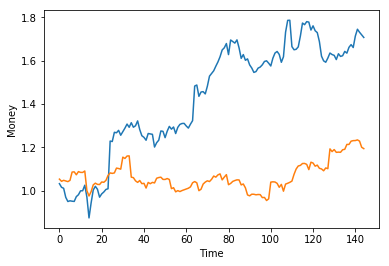

In [452]:
plt.plot(profitMulti)
plt.plot(RandomInvest)
plt.xlabel("Time")
plt.ylabel("Money")
plt.show()

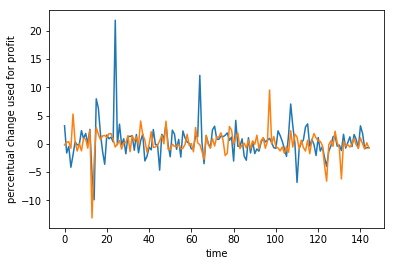

In [453]:
plt.plot(MaxPercentage)
plt.plot(RandomPercentage)
plt.ylabel("percentual change used for profit")
plt.xlabel("time")
plt.show()

In [454]:
from scipy import stats
stats.describe(MaxPercentage)

DescribeResult(nobs=145, minmax=(-9.8877382685270589, 21.834787209584512), mean=0.41319679849834212, variance=9.2146241228531469, skewness=2.5417567794956497, kurtosis=17.959568374491393)

In [455]:
from scipy import stats
stats.describe(RandomPercentage)

DescribeResult(nobs=145, minmax=(-13.095956514240722, 9.4973279794815806), mean=0.11198669238103658, variance=4.1631926925414007, skewness=-1.4505004343904953, kurtosis=14.709383267238557)

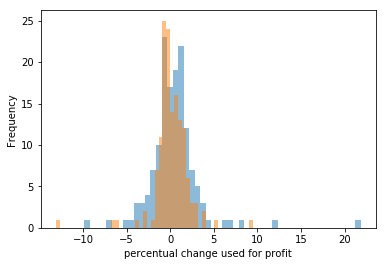

In [456]:
plt.hist(MaxPercentage, bins=50,alpha=0.5)
plt.hist(RandomPercentage, bins=50,alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("percentual change used for profit")
plt.show()

## 6.2 Profit for single company forecast

#### In this section univariate forecasting is tested for profit (MLP type 1)

Create X and y for procentual change prediction

In [386]:
X_test_cont = np.copy(AppleData[1:,:])
y_test_cont = pd.DataFrame(AppleTarget,copy=True)
y_temp = y_test_cont.copy(deep=True)
i=0
for entry in AppleTarget:
    
    if (i!=0):
        #print(y_test_cont.iloc[i])
        y_test_cont.iloc[i] = 100*(y_temp.iloc[i]-y_temp.iloc[i-1])/y_temp.iloc[i-1]
    i=i+1
y_test_cont=y_test_cont[1:].values

Predict for X_test_cont and transform y_pred_cont to percentual values

In [387]:
model = baseline_model()
model.load_weights('saved_models/weights.best.from_scratch_MLPtype1_WBC.hdf5')

y_pred_cont = model.predict(X_test_cont)

In [388]:
y_pred_cont_df = pd.DataFrame(y_pred_cont)
i=0
for entry in y_pred_cont:
    
    #print(y_test_cont.iloc[i])
    y_pred_cont_df.iloc[i] = 100*(y_pred_cont_df.iloc[i]-y_temp.iloc[i])/y_temp.iloc[i]
    i=i+1
y_pred_cont=y_pred_cont_df.values

Calculate expected money gain if invested only for >0 prediction

In [389]:
test = np.concatenate((y_pred_cont,y_test_cont),axis=1)
print(test.shape)
Y_total = pd.DataFrame(test,columns=["y_pred","y_test"])
#print(test[:30])
Y_total.head()

(1007, 2)


,y_pred,y_test
0,-5.319830,-0.966853
1,-4.079511,-0.325427
2,-2.899227,0.046644
3,-1.934257,-2.144526
4,-0.163000,4.335404


Predict profit only for test samples

In [390]:
Y_total = Y_total[862:].reset_index(drop=True)

In [391]:
profitsingle =[]
Time = []
startmoney = 1.0
for entry in Y_total.index:
    
    if Y_total.iloc[entry]["y_pred"] > 0:
        startmoney = startmoney+(startmoney*Y_total.iloc[entry]["y_test"]/100)
        profitsingle.append(startmoney)
        Time.append(entry)

comparison to put money everyday 

In [392]:
singleeveryday =[]
TimeEvery=[]
startmoney = 1.0
for entry in Y_total.index:
    startmoney = startmoney+(startmoney*Y_total.iloc[entry]["y_test"]/100)
    singleeveryday.append(startmoney)
    TimeEvery.append(entry)

- Plot results for Apple

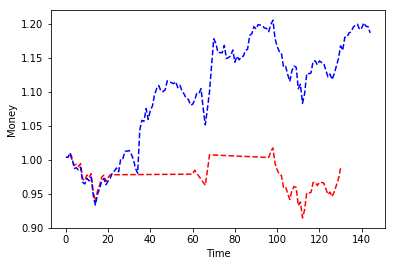

In [365]:
plt.plot(Time,profitsingle,"r--",TimeEvery, singleeveryday,"b--")
plt.xlabel("Time")
plt.ylabel("Money")
plt.show()

- Plot results for WBC

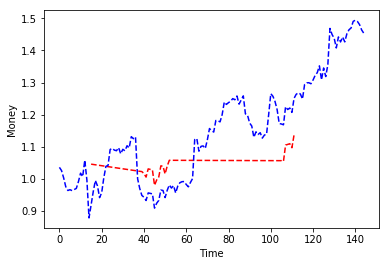

In [393]:
plt.plot(Time,profitsingle,"r--",TimeEvery, singleeveryday,"b--")
plt.xlabel("Time")
plt.ylabel("Money")
plt.show()

- Plot results for Fox

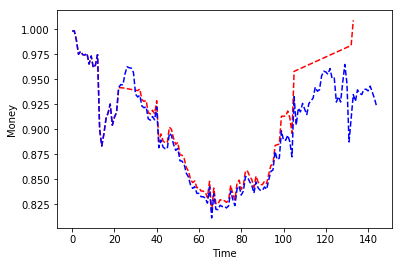

In [383]:
plt.plot(Time,profitsingle,"r--",TimeEvery, singleeveryday,"b--")
plt.xlabel("Time")
plt.ylabel("Money")
plt.show()